# Parse Antibiotic Resistance Ontology (ARO)

In [1]:
from ddot import Ontology
import ddot
ont2 = Ontology.from_table('/home/hermuba/data0118/network1122/candidate_ontologies')

/home/hermuba/miniconda3/envs/ddot/lib/python3.6/site-packages/ddot/Ontology.py:1606: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  table = pd.read_table(table, comment='#', header=header)


In [2]:
import io
import pandas as pd
def parse_obo(obo,
              output_file=None,
              id2name_file=None,
              id2namespace_file=None,
              alt_id_file=None):
    """Parses an OBO file and writes the results into several tables.

    Parameters
    ----------
    obo : str

        Filename of OBO file

    output_file : str

        Filename to write table that describes the ontology's
        hierarchical structure. The table has four columns: (1) parent
        term, (2) child term, (3) relation type (e.g. "is_a" or
        "part_of"), (4) namespace of relation
        (e.g. "biological_process" or "cellular component")

    id2name_file : str

        Filename to write table of term descriptions.  The table has
        two columns: (1) Ontology term (e.g. "GO:0000030"), (2)
        description (e.g. "mannosyltransferase activity")

    id2namespace_file : str
    
        Filename to write table of term namespaces.  The table has two
        columns: (1) Ontology term (e.g. "GO:0000030"), (2) namespace
        of the term (e.g. "biological_process")

    alt_id_file : str
    
        Filename to write table of alternative Term IDs that are
        synonyms and refer to the same term. The table has two
        columns: (1) Primary Term ID, (2) Alternative Term ID

    """

    ## Keywords that screw up parsing:
    # import, is_anonymous, intersection_of, union_of

    ## Relations
    # 'is_a:'
    # 'relationship: has_part'  # Not in filtered GO
    # 'relationship: occurs_in' # Not in filtered GO
    # 'relationship: part_of'   
    # 'relationship: positively_regulates' 
    # 'relationship: negatively_regulates'
    # 'relationship: regulates'
    # 'relationship: results_in' # Not in filtered GO

    stanza, edges = [], []
    id2name = dict()
    id2namespace = dict()
    alt_id = dict()
    in_term_stanza = False
    default_namespace_exists = False
    for line in io.open(obo).read().splitlines():

        line = line.split('!')[0].strip()  # Remove comments

        if len(line)>0 and line[0]=='[' and line[-1]==']':
            # Add last stanza if it was a term stanza.  Include namespace.
            if in_term_stanza:
                edges.extend(x+(namespace, ) for x in stanza)

            # Start new term stanza
            stanza = []
            
            # Set the default namespace, if it exists
            if default_namespace_exists:
                namespace = default_namespace
            
            # In a term stanzo or not
            in_term_stanza = line =='[Term]'

            name = None
                
        #if 'alt_id:' in line: assert False

        if 'id:' == line[:3]:
            curr_term = line.split('id:')[1].strip()
        elif 'alt_id:' in line:
            alt_term = line.split('alt_id:')[1].strip()
            if curr_term in alt_id:  alt_id[curr_term].append(alt_term)
            else:                          alt_id[curr_term] = [alt_term]
            id2name[alt_term] = name
        elif 'name:' in line:
            name = line.split('name:')[1].strip()
            #assert not curr_term in id2name
            id2name[curr_term] = name
        elif 'is_a:' in line:
            parent = line.split('is_a:')[1].strip()
            stanza.append((parent, curr_term, 'is_a'))
        elif 'relationship:' in line:
            line = line.split('relationship:')[1].strip().split()
            if len(line)!=2: print(line)
            assert len(line)==2
            relation, parent = line
            stanza.append((parent, curr_term, relation))
        elif 'namespace:' == line[:10]:
            namespace = line.split('namespace:')[1].strip()
            assert not curr_term in id2namespace
            id2namespace[curr_term] = namespace
        elif 'default-namespace:' == line[:18]:
            namespace = line.split('default-namespace:')[1].strip()
            default_namespace_exists = True
            default_namespace = namespace

    pd.DataFrame(edges).to_csv(output_file, header=False, index=False, sep='\t')
    pd.Series(id2name).to_csv(id2name_file, sep='\t')
    pd.Series(id2namespace).to_csv(id2namespace_file, sep='\t')
    pd.Series(dict([(a, c) for a, b in alt_id.items() for c in b])).to_csv(alt_id_file, sep='\t')

In [3]:
parse_obo('/home/hermuba/data0118/ontologies/aro.obo', '/home/hermuba/data0118/ontologies/aro_output')

/home/hermuba/miniconda3/envs/ddot/lib/python3.6/site-packages/ipykernel_launcher.py:116: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
/home/hermuba/miniconda3/envs/ddot/lib/python3.6/site-packages/ipykernel_launcher.py:117: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
/home/hermuba/miniconda3/envs/ddot/lib/python3.6/site-packages/ipykernel_launcher.py:118: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


## Create gene-term mapping

In [4]:
import pandas as pd
gold_anno = pd.read_pickle('/home/hermuba/data0118/goldstandard/ec_rmplasmid_node_anno_df')
new_res_genes = gold_anno.loc[ont2.genes] 

In [5]:
new_res_genes.head()

,cog_ID,cog_category,cluster,count,core,loose_best_ARO,loose_ARO,strict_best_ARO,strict_ARO,is_card,resfam,aclame_title,is_aclame,nr,hypo_nr,drug_target,is_drug_target,GO,pathway,domain
562.10576.con.0008_20|562.10576,COG2271,G,Cluster 4469,7.0,False,NaN,NaN,NaN,NaN,False,NaN,protein:plasmid:25502 Length: 467 # NCBI annot...,True,WP_000053689.1 MFS transporter [Escherichia coli],NaN,NaN,False,"{GO:0055085, GO:0022857, GO:0016021}",NaN,"{IPR020846, IPR000849, IPR036259, IPR011701}"
562.10576.con.0029_46|562.10576,COG2194,R,Cluster 2710,4.0,False,NaN,NaN,MCR-1,ARO:3003689,True,NaN,protein:plasmid:113751 Length: 580 # NCBI anno...,True,WP_049589868.1 MULTISPECIES: phosphoethanolami...,NaN,NaN,False,"{GO:0016021, GO:0008484, GO:0003824}",NaN,"{IPR000917, IPR017850, IPR012549}"
562.10576.con.0045_7|562.10576,COG3173,R,Cluster 7872,2.0,False,NaN,NaN,APH(4)-Ia,ARO:3002655,True,"{APH3, APH3'}",NaN,False,AEG42736.1 HygR [Cloning vector pPLV03],NaN,NaN,False,NaN,NaN,"{IPR002575, IPR011009}"
562.10576.con.0045_9|562.10576,COG2746,V,Cluster 11944,2.0,False,NaN,NaN,AAC(3)-IV,ARO:3002539,True,{AAC3},NaN,False,"6MN3_A Chain A, Crystal structure of aminoglyc...",NaN,NaN,False,"{GO:0046353, GO:0046677}",NaN,"{IPR003679, IPR028345}"
562.10576.con.0047_4|562.10576,COG2814,G,Cluster 5537,6.0,False,NaN,NaN,floR,ARO:3002705,True,"{Chlor_Efflux_Pump, emrB, MFS_efflux, TetA, Te...",protein:plasmid:116340 Length: 404 # NCBI anno...,True,WP_000214122.1 MULTISPECIES: chloramphenicol/f...,NaN,NaN,False,"{GO:0006855, GO:0015238, GO:0055085, GO:0016021}",NaN,"{IPR020846, IPR004812, IPR036259, IPR011701}"


In [6]:
# combine loose and strict ARO into Gene-Term Table
new_res_genes['strict_ARO'].count()

96

In [7]:
new_res_genes['loose_ARO'].count()

238

In [8]:
def gene_term_table(new_res_genes, term):
    term_table = pd.DataFrame()
    term_index = 0
    
        

In [9]:
aro = new_res_genes['strict_ARO'].dropna().append(new_res_genes['loose_ARO'].dropna()) # when has strict card, won't have loose card
# generate gene_term list: one gene-term per row
aro_list = []
for gene in aro.index:
    aro_many = aro[gene].split(', ')
    for aro_term in aro_many:
        aro_list.append((gene, aro_term))

In [10]:
gene_term_mapping = pd.DataFrame(aro_list, columns = ['gene', 'aro_term'])
gene_term_mapping.head()

,gene,aro_term
0,562.10576.con.0029_46|562.10576,ARO:3003689
1,562.10576.con.0045_7|562.10576,ARO:3002655
2,562.10576.con.0045_9|562.10576,ARO:3002539
3,562.10576.con.0047_4|562.10576,ARO:3002705
4,562.22437.con.0041_3|562.22437,ARO:3002858


# Construct ARO in ddot

In [11]:
aro_ontology = Ontology.from_table('/home/hermuba/data0118/ontologies/aro_output', mapping = gene_term_mapping, mapping_parent = 'aro_term', mapping_child = 'gene')

/home/hermuba/miniconda3/envs/ddot/lib/python3.6/site-packages/ddot/Ontology.py:1606: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  table = pd.read_table(table, comment='#', header=header)
/home/hermuba/miniconda3/envs/ddot/lib/python3.6/site-packages/ddot/Ontology.py:1630: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  mapping = pd.read_table(mapping, comment='#', header=header)


In [12]:
aro_ontology

334 genes, 4096 terms, 9539 gene-term relations, 7810 term-term relations
node_attributes: []
edge_attributes: ['antibiotic_resistance', 'is_a']

# Align our ontology to ARO

In [13]:
# align CliXO to ARO
align_aro = ont2.align(aro_ontology)

collapse command: /home/hermuba/miniconda3/envs/ddot/lib/python3.6/site-packages/ddot/alignOntology/collapseRedundantNodes /tmp/tmph8hx34ar


/home/hermuba/miniconda3/envs/ddot/lib/python3.6/site-packages/ddot/Ontology.py:713: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  names=['Child', 'Parent'])


collapse command: /home/hermuba/miniconda3/envs/ddot/lib/python3.6/site-packages/ddot/alignOntology/collapseRedundantNodes /tmp/tmpnnjol3fe
Alignment command: /home/hermuba/miniconda3/envs/ddot/lib/python3.6/site-packages/ddot/alignOntology/calculateFDRs /tmp/tmpidtoh0ic /tmp/tmpv95wibxi 0.05 criss_cross /tmp/tmpcrkje9xc 100 40 gene


/home/hermuba/miniconda3/envs/ddot/lib/python3.6/site-packages/ddot/Ontology.py:150: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  header=None)


In [14]:
align_aro.head()

,Term,Similarity,FDR
Term,,,
S:582,ARO:3002804,0.905955,0.0
S:590,ARO:3002594,0.884570,0.0
S:589,ARO:3002660,0.883425,0.0
S:608,ARO:3000676,0.879019,0.0
S:630,ARO:3004126,0.878897,0.0


In [15]:
align_aro.shape

(180, 3)

In [16]:
align_aro.index.name = None

In [17]:
align_aro.reset_index(inplace = True)

# Statistics of this alignment

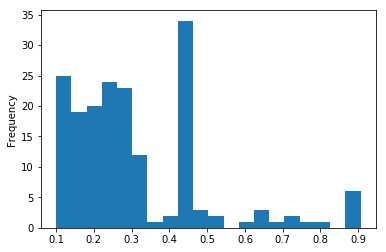

In [18]:
%matplotlib inline
align_aro['Similarity'].plot.hist(bins = 20) # most are with low similarity

In [19]:
align_aro['FDR'].max() #weird

0.0

# Annotate those Terms with ARO's annotation

In [20]:
aro_name = pd.read_csv('~/data0118/ontologies/aro.tsv', header = 0, sep = '\t')

In [21]:
aro_name.head()

,Accession,Name,Description
0,ARO:0000000,macrolide antibiotic,Macrolides are a group of drugs (typically ant...
1,ARO:0000001,fluoroquinolone antibiotic,The fluoroquinolones are a family of synthetic...
2,ARO:0000002,tetracycline-resistant ribosomal protection pr...,A family of proteins known to bind to the 30S ...
3,ARO:0000003,astromicin,Astromicin is an aminoglycoside antibiotic use...
4,ARO:0000004,monobactam,Monobactams are a class of beta-lactam antibio...


In [22]:
align_aro = align_aro.merge(aro_name, left_on = 'Term', right_on = 'Accession', how = 'inner')

# use the aligned terms to annotate out ontology

In [23]:
align_aro.to_csv('~/data0118/network1122/candidate_ontologies_term_anno.csv')

# Show case some ontology

In [24]:
align_aro.set_index('index', inplace = True)


In [25]:
align_aro.head()

,Term,Similarity,FDR,Accession,Name,Description
index,,,,,,
S:582,ARO:3002804,0.905955,0.0,ARO:3002804,FosA2,An enzyme that confers resistance to fosfomyci...
S:590,ARO:3002594,0.884570,0.0,ARO:3002594,AAC(6')-IIa,AAC(6')-IIa is an aminoglycoside acetyltransfe...
S:589,ARO:3002660,0.883425,0.0,ARO:3002660,APH(6)-Id,APH(6)-Id is an aminoglycoside phosphotransfer...
S:608,ARO:3000676,0.879019,0.0,ARO:3000676,H-NS,H-NS is a histone-like protein involved in glo...
S:630,ARO:3004126,0.878897,0.0,ARO:3004126,Escherichia coli LamB,LamB is a negative regulator for antibiotic re...


In [26]:
import numpy as np
def map_annotation_to_igraph(igraph_obj, align_aro, new_res_genes, node_lbl = 'aro'):
    ''' to map annotation to igraph object for the purpose of visualization
    '''
    keys = igraph_obj.vs['name'] # id are stored in here
    # weird .0 is added
    keys = [i[:-2] for i in keys]
    
    igraph_obj.vs['size'] = [20 if 'S:' in i else 10 for i in keys]
    igraph_obj.vs['label_size'] = [12 if 'S:' in i else 6 for i in keys]
    
    # resfam annotation(gene)
    igraph_obj.vs['resfam'] = [new_res_genes.loc[i, 'resfam'] if i in new_res_genes.index else '' for i in keys]
    # aro annotation (gene use name, term use align aro)
    igraph_obj.vs['aro'] = [new_res_genes.loc[i, 'strict_best_ARO'] if i in new_res_genes.index else align_aro.loc[i, 'Name'] if i in align_aro.index else '' for i in keys]
    # nr annotation
    igraph_obj.vs['nr'] = [new_res_genes.loc[i, 'nr'] if i in new_res_genes.index else '' for i in keys]
    # hypothetical or not
    igraph_obj.vs['hypo'] = [new_res_genes.loc[i, 'hypo_nr'] if i in new_res_genes.index else '' for i in keys]
    # composite
    if node_lbl == 'aro':
        igraph_obj.vs['label'] = [new_res_genes.loc[i, 'strict_best_ARO'] if i in new_res_genes.index else align_aro.loc[i, 'Name'] if i in align_aro.index else '' for i in keys]
    else:
        igraph_obj.vs['label'] = [new_res_genes.loc[i, 'resfam'] if i in new_res_genes.index else align_aro.loc[i, 'Name'] if i in align_aro.index else '' for i in keys]
    igraph_obj.vs['label'] = [i if type(i)==str else '' for i in igraph_obj.vs['label']]
    
    color_list = []
    for i in keys:
        if 'S:' in i:
            color_list.append('grey')
        elif new_res_genes.loc[i, 'hypo_nr'] == True:
            color_list.append('blue')
        else:
            color_list.append('pink')
    igraph_obj.vs['color'] = color_list
    return(igraph_obj)

In [27]:
align_aro.loc['S:787']

Term                                                 ARO:3000750
Similarity                                              0.715381
FDR                                                            0
Accession                                            ARO:3000750
Name           protein of two-component regulatory system mod...
Description    A protein, either a histidine kinase or a resp...
Name: S:787, dtype: object

In [28]:
s787 = ont2.focus(branches = 'S:787').unfold().to_igraph()

Genes and Terms to keep: 126


/home/hermuba/miniconda3/envs/ddot/lib/python3.6/site-packages/ddot/Ontology.py:1606: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  table = pd.read_table(table, comment='#', header=header)


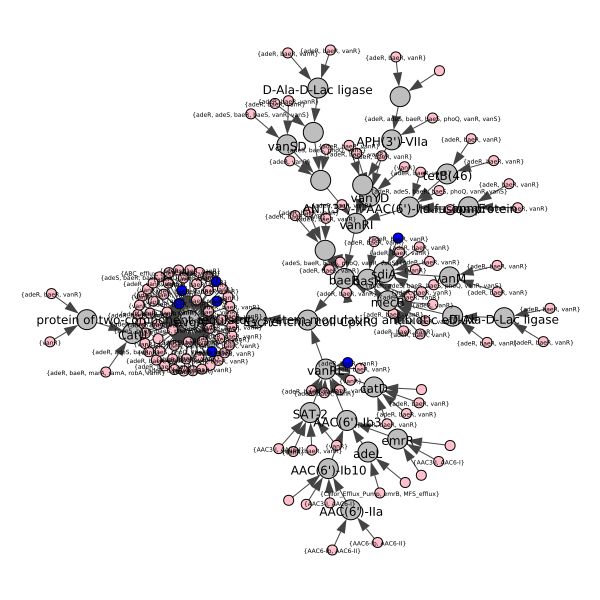

In [29]:
root_dir = '~/data0118/fig/'
from igraph import *
s787 = map_annotation_to_igraph(s787, align_aro, new_res_genes, node_lbl = 'aro')
layout = s787.layout("kk")
plot(s787, "s787_aro.pdf", layout = layout, margin = 50)

s787 = map_annotation_to_igraph(s787, align_aro, new_res_genes, node_lbl = 'resfam')

plot(s787, "s787_resfam.pdf", layout = layout, margin = 50)

In [30]:
align_aro.loc['S:761']

Term                                                 ARO:3003922
Similarity                                              0.619966
FDR                                                            0
Accession                                            ARO:3003922
Name                                                        oqxA
Description    RND efflux pump conferring resistance to fluor...
Name: S:761, dtype: object

Genes and Terms to keep: 45


/home/hermuba/miniconda3/envs/ddot/lib/python3.6/site-packages/ddot/Ontology.py:1606: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  table = pd.read_table(table, comment='#', header=header)


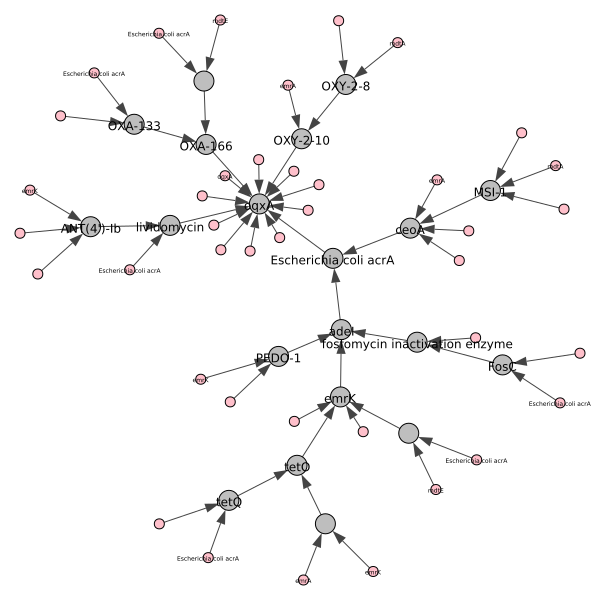

In [31]:
s761 = ont2.focus(branches = 'S:761').unfold().to_igraph()
map_annotation_to_igraph(s761, align_aro, new_res_genes)
layout = s761.layout("kk")
plot(s761, layout = layout)

Genes and Terms to keep: 29


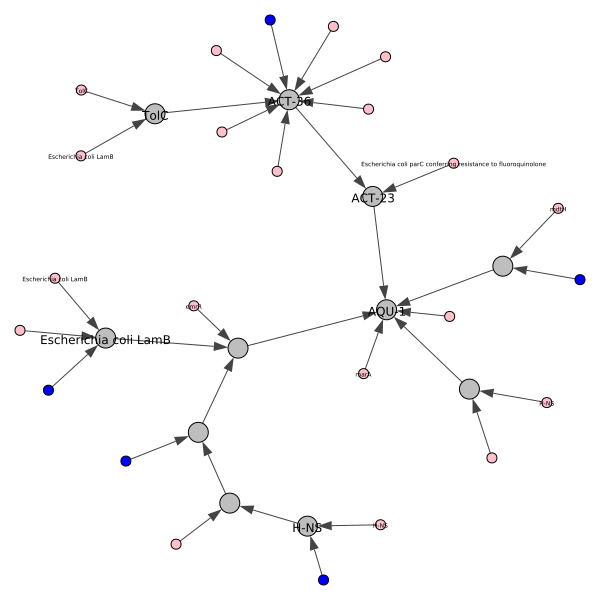

In [32]:
s790 = ont2.focus(branches = 'S:752').unfold().to_igraph()
map_annotation_to_igraph(s790, align_aro, new_res_genes)
layout = s790.layout("fr")
plot(s790, layout = layout)